load all packages

In [1]:
#standard packages
import numpy as np
from numpy import concatenate
import pandas as pd
import glob
import math

from statsmodels.tools.eval_measures import rmse
import warnings

#plot packages
from matplotlib import pyplot
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)

#package to create date-time objects
import datetime as dt

#performance measures
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

#RF packages
from sklearn.ensemble import RandomForestRegressor

from tqdm import tqdm
from IPython.utils import io
from sklearn.tree import export_graphviz
from sklearn import tree

from timeit import default_timer as timer
from datetime import timedelta
import tensorflow as tf

from scipy.stats import kstest

In [2]:
def _naive_forecasting(actual: np.ndarray, seasonality):
    return actual[:-seasonality]

In [3]:
def mean_absolute_scaled_error(actual: np.ndarray, predicted: np.ndarray, seasonality):
    #Baseline (benchmark) is computed with naive forecasting shifted bu seasonality
    return mean_absolute_error(actual, predicted) / mean_absolute_error(actual[seasonality:], _naive_forecasting(actual, seasonality))

In [4]:
def mean_directional_accuracy(y, y_hat):
    #Mean Directional Accuracy
    return np.mean(np.sign(y.diff()[1:]) == np.sign(y_hat[1:] - y_hat[:-1]))
    # the reason the two diffrence are diffrentely computed is because y is inputed as dataframe column but yhat is a array. 
    #If this is diffrent then change.

# Data preparation

Read csv file from your documents. This line is different for each user. In the dataset the date variable is just the date not the date-time, we know date is half hourly thus we can add the time. the date variable from now on will be called ds and the variable we would like to predict y. The name of the extra regressors is not important. And lastly, we drop the varibales that are unimportant and can not be used for as extra regressors

In [5]:
df = pd.read_csv(r'C:\Users\Britt\Documents\DataAnalyse\data\half_hour.txt', sep="\t")
df.date = pd.date_range(df.date[0] , periods = len(df.date), freq='30min')
df.rename(columns={'date' : 'ds', 'count' : 'y'}, inplace=True)
df.drop(['AvgService'], axis=1, inplace=True)

Set the size of the training dataset and subsequently the length of the test dataset

In [6]:
len_trainset = round(0.8*len(df))

We create some extra regressors to decribe the seasonality

In [7]:
df['hour'] = df['ds'].dt.hour
df['weekday'] =df['ds'].dt.weekday
df['month'] = df['ds'].dt.month
df['year'] = df['ds'].dt.year

In [8]:
df.head()

,ds,kperiod,irregular,holiday,y,DeliverD1,DeliverD7,DeliverD14,DeliverD21,Bill1,Bill7,Bill14,Bill21,Deliver,hour,weekday,month,year
0,2004-02-14 00:00:00,1,0,0,55,0,0,0,0,0,0,0,0,0,0,5,2,2004
1,2004-02-14 00:30:00,2,0,0,63,0,0,0,0,0,0,0,0,0,0,5,2,2004
2,2004-02-14 01:00:00,3,0,0,32,0,0,0,0,0,0,0,0,0,1,5,2,2004
3,2004-02-14 01:30:00,4,0,0,38,0,0,0,0,0,0,0,0,0,1,5,2,2004
4,2004-02-14 02:00:00,5,0,0,19,0,0,0,0,0,0,0,0,0,2,5,2,2004


Now we split the data into the labels which are the values for y the varibale we would like to predict. And the features which are the extra regressors

In [10]:
labels = df['y']
features= df.drop('y', axis = 1)
features = features.set_index('ds') #ds is not part of the features but is set as index.
feature_list = list(features.columns) #list with exogenous varibales names

Then we split the data into the train and test set for both the labels and features.

In [12]:
train_features = features.iloc[:len_trainset,:]
train_labels = labels.iloc[:len_trainset]
#test data
test_features = features.iloc[len_trainset:,:]
test_labels = labels.iloc[len_trainset:]

In [13]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (12365, 16)
Training Labels Shape: (12365,)
Testing Features Shape: (3091, 16)
Testing Labels Shape: (3091,)


# Random forest

Then we fit the model on the training set

In [14]:
start = timer()
rf = RandomForestRegressor(n_estimators = 500, random_state = 15)
# Train the model on training data
rf.fit(train_features, train_labels);
end = timer()
runtime = end-start
print(runtime)

11.815675200000044


Now we predict

In [15]:
predictions = rf.predict(features)

# Results

In [16]:
y_true_train = df['y'][:len_trainset]
y_true_test = df['y'][len_trainset:]
y_pred_train = predictions[:len_trainset]
y_pred_test = predictions[len_trainset:]

MAEtrain = mean_absolute_error(y_true_train, y_pred_train)
MAEtest = mean_absolute_error(y_true_test, y_pred_test)

print('train MAE', round(MAEtrain, 2))
print('test MAE',  round(MAEtest,2))

train MAE 15.08
test MAE 27.58


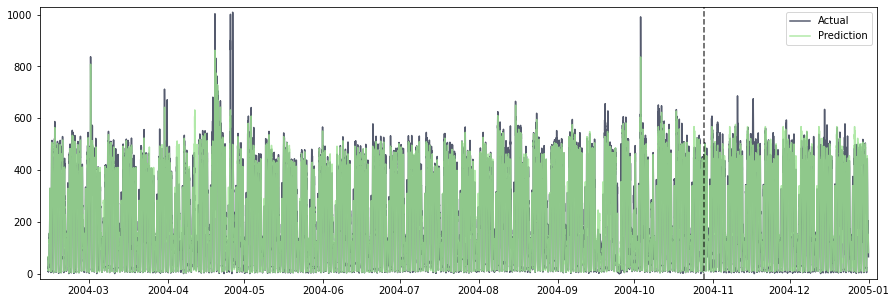

In [17]:
plt.plot(np.asarray(df.ds, dtype='datetime64[s]'), df.y, color= '#555B6E', label = 'Actual')
plt.plot(np.asarray(df.ds, dtype='datetime64[s]'), predictions, color='#9EE493', label = 'Prediction', alpha=0.8)
plt.axvline(x=np.asarray(df.ds, dtype='datetime64[s]')[len_trainset], color='k', linestyle='--', alpha=0.7)
plt.margins(x=0.01)
plt.margins(y=0.02)
plt.legend()

Zoom in on the test set

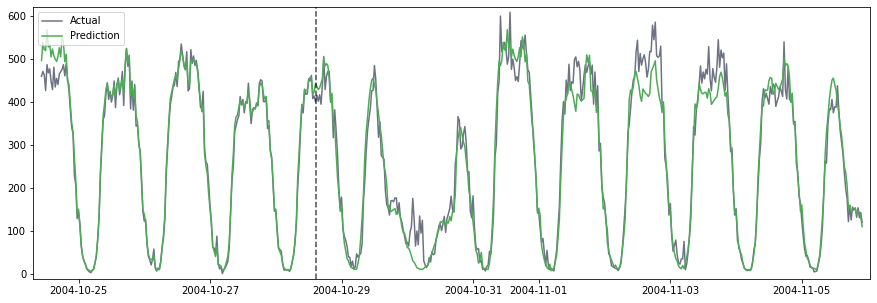

In [19]:
zoom1 = 200 #amount of observation from the train set you see
zoom2 = 400 #amount of observation from test you see

plt.rcParams["figure.figsize"] = (15,5)
fig = plt.figure()

plt.plot(np.asarray(df.ds, dtype='datetime64[s]')[len_trainset-zoom1:len_trainset+zoom2], df.y[len_trainset-zoom1:len_trainset+zoom2], color= '#555B6E', label = 'Actual', alpha=0.85)
plt.plot(np.asarray(df.ds, dtype='datetime64[s]')[len_trainset-zoom1:len_trainset+zoom2], predictions[len_trainset-zoom1:len_trainset+zoom2], color='#4DAA57', label = 'Prediction', alpha=1)
plt.axvline(x=np.asarray(df.ds, dtype='datetime64[s]')[len_trainset], color='k', linestyle='--', alpha=0.7)
plt.legend(loc="upper left")
plt.margins(x=0.01)
plt.margins(y=0.02)

<H3> Remove unimportant varibles

In [20]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: kperiod              Importance: 0.65
Variable: weekday              Importance: 0.18
Variable: hour                 Importance: 0.09
Variable: holiday              Importance: 0.04
Variable: month                Importance: 0.02
Variable: irregular            Importance: 0.01
Variable: DeliverD1            Importance: 0.0
Variable: DeliverD7            Importance: 0.0
Variable: DeliverD14           Importance: 0.0
Variable: DeliverD21           Importance: 0.0
Variable: Bill1                Importance: 0.0
Variable: Bill7                Importance: 0.0
Variable: Bill14               Importance: 0.0
Variable: Bill21               Importance: 0.0
Variable: Deliver              Importance: 0.0
Variable: year                 Importance: 0.0


Retrive 3 most important variables.

In [21]:
result_list = [feature_importances[i][0] for i in range(4)]

Train new random forest

In [24]:
# New random forest with only the two most important variables
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=15)

important = features[result_list]
train_important = train_features[result_list]
test_important = test_features[result_list]

# Train the random forest
rf_most_important.fit(train_important, train_labels)

RandomForestRegressor(n_estimators=1000, random_state=15)

make new predictions

In [29]:
new_predictions = rf_most_important.predict(important)

In [31]:
y_true_train = df['y'][:len_trainset]
y_true_test = df['y'][len_trainset:]
y_pred_train = new_predictions[:len_trainset]
y_pred_test = new_predictions[len_trainset:]

MAEtrain = mean_absolute_error(y_true_train, y_pred_train)
MAEtest = mean_absolute_error(y_true_test, y_pred_test)
print('train MAE', MAEtrain)
print('test MAE', MAEtest)

train MAE 29.232883849139412
test MAE 25.310332382550467


While the pruned random forest has higher insample MAE it has lower out-of sample MAE

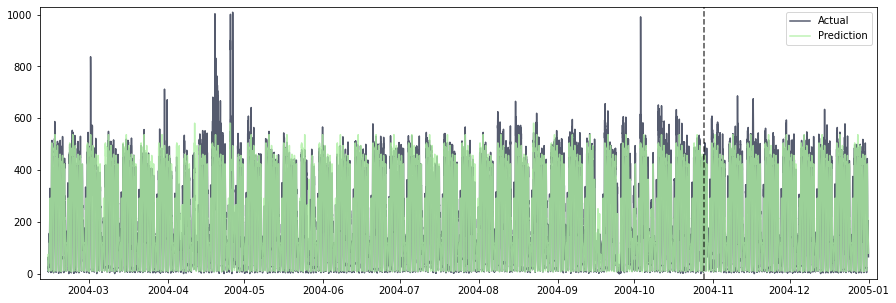

In [32]:
plt.plot(np.asarray(df.ds, dtype='datetime64[s]'), df.y, color= '#555B6E', label = 'Actual')
plt.plot(np.asarray(df.ds, dtype='datetime64[s]'), new_predictions, color='#aef0a3', label = 'Prediction', alpha=0.8)
plt.axvline(x=np.asarray(df.ds, dtype='datetime64[s]')[len_trainset], color='k', linestyle='--', alpha=0.7)
plt.margins(x=0.01)
plt.margins(y=0.02)
plt.legend()

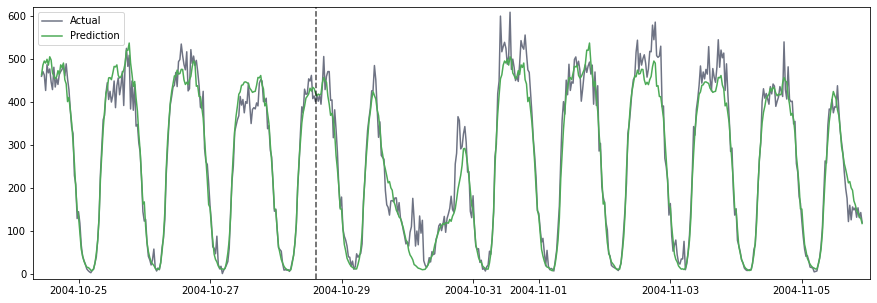

In [34]:
zoom1 = 200 #amount of observation from the train set you see
zoom2 = 400 #amount of observation from test you see

plt.rcParams["figure.figsize"] = (15,5)
fig = plt.figure()

plt.plot(np.asarray(df.ds, dtype='datetime64[s]')[len_trainset-zoom1:len_trainset+zoom2], df.y[len_trainset-zoom1:len_trainset+zoom2], color= '#555B6E', label = 'Actual', alpha=0.85)
plt.plot(np.asarray(df.ds, dtype='datetime64[s]')[len_trainset-zoom1:len_trainset+zoom2], new_predictions[len_trainset-zoom1:len_trainset+zoom2], color='#4DAA57', label = 'Prediction', alpha=1)
plt.axvline(x=np.asarray(df.ds, dtype='datetime64[s]')[len_trainset], color='k', linestyle='--', alpha=0.7)
plt.legend(loc="upper left")
plt.margins(x=0.01)
plt.margins(y=0.02)

# graph

The random forest exists out of many regression trees, to better understand the random forest we look at a single tree. The trees from the original random forest would be to big to picture thus we train a new forest with a max_depth: meaning we set the numbe of splits to 3.

In [35]:
# Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
rf_small.fit(train_features, train_labels)
# Extract the small tree
tree_small = rf_small.estimators_[5]

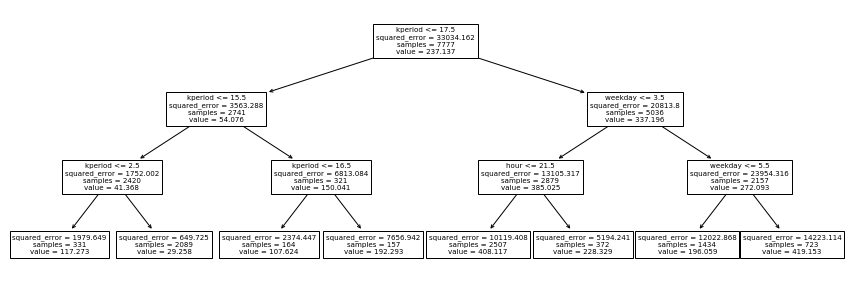

In [36]:
#fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(tree_small, feature_names = train_features.columns, filled = False);